# Feature Engineering:

Not all NAs are missing data! Some are Missing Not at Random, such as Fence Type which indicates that there's no fence!

## Plan of attack:

1. Determine the nature of each feature
2. Encode categorical features
3. Linearize numerical features (for linear algorithms)
4. Impute missing data
5. Create new features based on interactions between existing features

# Set up environment

In [186]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("dark")
import time
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
import pickle
from scipy.stats import boxcox

# Load dataset

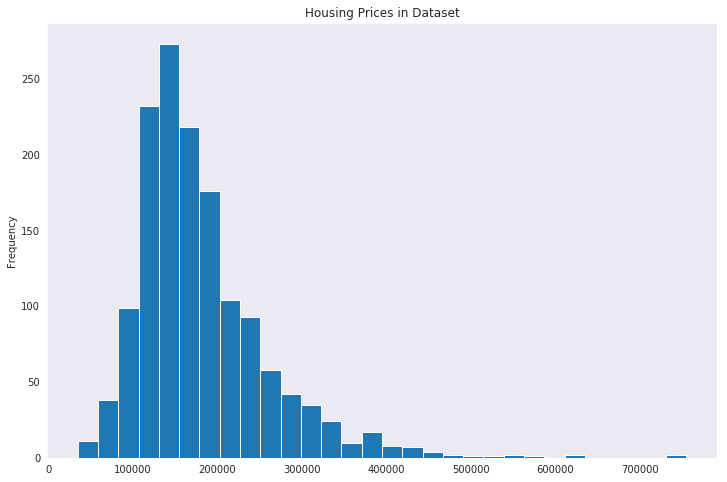

In [187]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

target_train = df_train.SalePrice
df_train.drop("SalePrice", axis=1, inplace=True)

df = pd.concat([df_train, df_test], sort=False)

df = df.set_index('Id')

p = target_train.plot(kind='hist', bins = 30)
ptitle = plt.title('Housing Prices in Dataset')

### Rename column names that are incompatible with Pandas (Periods and numerics)

In [188]:
df.columns = list(map(lambda x: x.replace(".","_").replace("1","_1").replace("2","_2").replace("3","_3").replace("___","_").replace("__","_"), df.columns))

In [189]:
df.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition_1,Condition_2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior_1st,Exterior_2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType_1,BsmtFinSF_1,BsmtFinType_2,BsmtFinSF_2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,_1stFlrSF,_2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,_3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732.0,Unf,0.0,64.0,796.0,GasA,Ex,Y,SBrkr,796,566,0,1362,1.0,0.0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2.0,480.0,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369.0,Unf,0.0,317.0,1686.0,GasA,Ex,Y,SBrkr,1694,0,0,1694,1.0,0.0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2.0,636.0,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859.0,BLQ,32.0,216.0,1107.0,GasA,Ex,Y,SBrkr,1107,983,0,2090,1.0,0.0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2.0,484.0,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,952.0,952.0,GasA,Gd,Y,FuseF,1022,752,0,1774,0.0,0.0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2.0,468.0,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml


# 1. Determine the nature of each feature

In [190]:
# All features of type "object" are likely categorical
objectCols = df.select_dtypes(include=['object']).columns

In [191]:
# All features of type "float" are likely numeric, but years can be converted to integer
floatCols = df.select_dtypes(include=['float']).columns

In [192]:
# All features of type "int" are mixed: some need to be converted to categorical and some are ordinalprint
intCols = df.select_dtypes(include=['int']).columns

In [193]:
boolCols = df.select_dtypes(include=['bool']).columns

In [194]:
# Am I missing any from the above lists? These should add up to 79
len(objectCols) + len(floatCols) + len(intCols) + len(boolCols)

79

In [195]:
# HouseStyle may be ordinal or can be converted to an integer of floors 
# If YearRemodAdd != YearBuild, that could be a new category
# Another is whether or not Exterior_1st == Exterior_2nd 
# MasVnrType has some NaN that might be reasonably considered "None", especially if its MasVnrArea == 0 
# Any square footages should be combined with quality of that object

## Automated dictionary creation for type of variable:

In [196]:
# featureTypes = [df.columns, df.dtypes]
# typeConvertDict = {}
# for feature in featureTypes:
#     print(feature[0])
#     sns.catplot(data = df, x = feature[0], kind='count')
#     plt.show()
#     #df[feature[0]].value_counts(dropna = False).plot( kind = 'bar')
#     currentSuggestion = str(input(prompt = "Ordinal, Categorical, Float, Integer, or Boolean?"))
#     typeConvertDict[feature[0]] = currentSuggestion

# import pickle

# f = open("typeConvertDict.pkl","wb")
# pickle.dump(typeConvertDict,f)
# f.close()

### Just load the feature types determined earlier

In [197]:
with open('typeConvertDict.pkl', 'rb') as handle:
    typeConvertDict = pickle.load(handle)
    
# f = open("typeConvertDict.pkl","wb")
# pickle.dump(typeConvertDict,f)
# f.close()

# typeConvertDict
typeConvertDict.pop("SalePrice", 0)

'Float'

## Ensure that the features' data types reflect what they contain (categories as strings, etc)

In [198]:
catList = [k for k,v in typeConvertDict.items() if v=="Categorical" or v=="Boolean"]
df[catList] = df[catList].astype(str)

ordList = [k for k,v in typeConvertDict.items() if v=="Ordinal"]
df[ordList] = df[ordList].astype(str)

floatList = [k for k,v in typeConvertDict.items() if v=="Float"]
df[floatList] = df[floatList].astype(float)

intList = [k for k,v in typeConvertDict.items() if  v=="Integer"]
df[intList] = df[intList].fillna(0).astype(int)

# 2a. Encoding categorical features

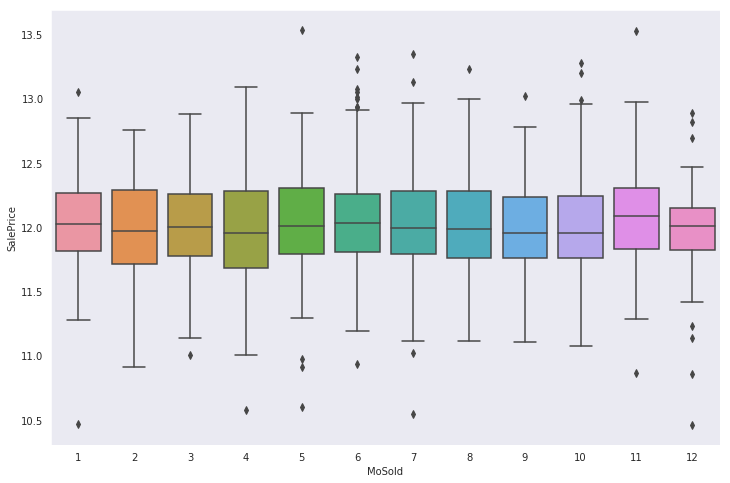

In [199]:
sns.boxplot(df.MoSold.apply(int), target_train.apply(np.log))


In [200]:
# Isolate categorical variables
print("The number of categorical features is " + str(len(catList)) + " before encoding")

# Drop useless ones:
catList.remove("Heating")
catList.remove('Fence')
catList.remove('MiscFeature')
catList.remove('SaleType')
catList.remove('SaleCondition')

# Apply One Hot Encoding to all categorical variables and check how many additional columns it makes
cat_df = pd.get_dummies(df[catList], drop_first=True)

print("The number of categorical features is " + str(cat_df.shape[1]) + " after encoding")

The number of categorical features is 26 before encoding
The number of categorical features is 155 after encoding


# 2b. Encoding ordinal features (all in this section have been linearized)

In [201]:
print("The number of ordinal features is " + str(len(ordList)) + " before encoding")

ord_df = df[ordList].copy()

# Lot shape to ordered integers:
preserved_mapper_LotShape = {"Reg" : 0, "IR1": 1, 'IR2':2, 'IR3':3}
ord_df['LotShape'] = ord_df.LotShape.replace(preserved_mapper_LotShape).apply(np.sqrt)

# There's only one home with less than full utilities, so I'm dropping it!
preserved_mapper_Utilities = {"AllPub":3, "NoSewr":2, "NoSeWa":1, "ELO":0}
ord_df['Utilities'] = ord_df.Utilities.replace(preserved_mapper_Utilities)
ord_df.drop("Utilities", axis = 1, inplace=True)

# Land Slope is linear but with a very weak effect
preserved_mapper_LandSlope = {"Gtl" : 0, "Mod": 1, 'Sev':2}
ord_df['LandSlope'] = ord_df.LandSlope.replace(preserved_mapper_LandSlope)

# Overall quality as float, but taken squared for linearity
ord_df['OverallQual'] = ord_df.OverallQual.astype(float)

# External quality as float, but taken squared for linearity
preserved_mapper_ExterQual = {"Po" : 1, "Fa": 2, 'TA':3, 'Gd':4, 'Ex':5}
ord_df['ExterQual'] = ord_df.ExterQual.replace(preserved_mapper_ExterQual)

# Basement quality is an integer since it's nearly linear
preserved_mapper_BsmtQual = {"nan":0, "Po" : 1, "Fa": 2, 'TA':3, 'Gd':4, 'Ex':5}
ord_df['BsmtQual'] = ord_df.BsmtQual.replace(preserved_mapper_BsmtQual).apply(np.square)

# Heating QC is converted to an ordered list and squared for linearity
preserved_mapper_HeatingQC = {"Po" : 0, "Fa": 1, 'TA':2, 'Gd':3, 'Ex':4}
ord_df['HeatingQC'] = ord_df.HeatingQC.replace(preserved_mapper_HeatingQC)
ord_df.drop('HeatingQC', axis=1, inplace=True)

# Kitchen quality is converted to an ordered list and squared for linearity
preserved_mapper_KitchenQual = {"nan":0, "Po" : 1, "Fa": 2, 'TA':3, 'Gd':4, 'Ex':5}
ord_df['KitchenQual'] = ord_df.KitchenQual.replace(preserved_mapper_KitchenQual)

# Fireplace quality isn't well represented as linear. CONSIDER ONE HOT
preserved_mapper_FireplaceQu = {"nan":0, "Po" : 1, "Fa": 2, 'TA':3, 'Gd':4, 'Ex':5}
ord_df['FireplaceQu'] = ord_df.FireplaceQu.replace(preserved_mapper_FireplaceQu)

# GarageQual is nonlinear and not correctable. CONSIDER ONE HOT
preserved_mapper_GarageQual = {"nan": 0, "Po" : 1, "Fa": 2, 'TA':3, 'Gd':4, 'Ex':5}
ord_df['GarageQual'] = ord_df.GarageQual.replace(preserved_mapper_GarageQual)
ord_df.drop('GarageQual', axis=1, inplace=True)

# GarageFinish
preserved_mapper_GarageFinish = {"nan":0, "Unf" : 1, "RFn": 2, 'Fin':3}
ord_df['GarageFinish'] = ord_df.GarageFinish.replace(preserved_mapper_GarageFinish)

# PavedDrive
preserved_mapper_PavedDrive = {"N":0, "P" : 1, "Y": 2}
ord_df['PavedDrive'] = ord_df.PavedDrive.replace(preserved_mapper_PavedDrive)
ord_df.drop('PavedDrive', axis=1, inplace=True)

## 
## BELOW ARE VARIABLES THAT ARE STILL NONLINEAR
##


# Overall condition seems like a nonlinear indicator with a huge range of values at 5! CONSIDER DROPPING IT
ord_df['OverallCond'] = ord_df.OverallCond.astype(float)

# External condition seems like a nonlinear indicator with a huge range of values at 5! CONSIDER DROPPING IT
preserved_mapper_ExterCond = {"Po" : 0, "Fa": 1, 'TA':2, 'Gd':3, 'Ex':4}
ord_df['ExterCond'] = ord_df.ExterCond.replace(preserved_mapper_ExterCond)

# Basement condition is nonlinear. NEED TO REMOVE ZEROS
preserved_mapper_BsmtCond = {"nan":0, "Po" : 1, "Fa": 2, 'TA':3, 'Gd':4, 'Ex':5}
ord_df['BsmtCond'] = ord_df.BsmtCond.replace(preserved_mapper_BsmtCond)

# Basement exposure is nonlinear. NEED TO REMOVE ZEROS
preserved_mapper_BsmtExposure = {"nan" : 0, "No": 1, 'Mn':2, 'Av':3, 'Gd': 4}
ord_df['BsmtExposure'] = ord_df.BsmtExposure.replace(preserved_mapper_BsmtExposure)

# GarageCond CONSIDER ONE HOT
preserved_mapper_GarageCond = {"nan": 0, "Po" : 1, "Fa": 2, 'TA':3, 'Gd':4, 'Ex':5}
ord_df['GarageCond'] = ord_df.GarageCond.replace(preserved_mapper_GarageCond)
ord_df.drop('GarageCond', axis = 1, inplace=True)

# PoolQC is extremely nonlinear. TURN BOOLEAN
preserved_mapper_PoolQC = {"nan":0, "Po" : 0, "Fa": 2, 'TA':3, 'Gd':4, 'Ex':5}
ord_df['PoolQC'] = ord_df.PoolQC.replace(preserved_mapper_PoolQC)
ord_df.drop('PoolQC', axis=1, inplace=True)

# BsmtFinType_1 DEFINITELY NONLINEAR
preserved_mapper_BsmtFinType_1 = {"nan":0, "Unf" : 1, "LwQ": 2, 'Rec':3, 'BLQ':4, 'ALQ':5, "GLQ": 6}
ord_df['BsmtFinType_1'] = ord_df.BsmtFinType_1.replace(preserved_mapper_BsmtFinType_1)
ord_df.drop('BsmtFinType_1', axis = 1, inplace=True)

# BsmtFinType_2 DEFINITELY NONLINEAR
preserved_mapper_BsmtFinType_2 = {"nan":0, "Unf" : 1, "LwQ": 2, 'Rec':3, 'BLQ':4, 'ALQ':5, "GLQ": 6}
ord_df['BsmtFinType_2'] = ord_df.BsmtFinType_2.replace(preserved_mapper_BsmtFinType_2)
ord_df.drop('BsmtFinType_2', axis = 1, inplace=True)

# Functionality is a weird one, not sure what to do with it.  CONSIDER MAKING SUB-GROUPS?
preserved_mapper_Functional = {"0":0, "nan":0, "Sev" : 1, "Maj2": 2, 'Maj1':3, 'Mod':4, 'Min2':5, "Min1": 6, "Typ": 7}
ord_df['Functional'] = ord_df.Functional.replace(preserved_mapper_Functional)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# sns.boxplot(num_df.MoSold, target_train.apply(np.log))

print(ordList)
print(ord_df.head())
print(ord_df.dtypes)

The number of ordinal features is 21 before encoding
['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType_1', 'BsmtFinType_2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC']
    LotShape  LandSlope  OverallQual  OverallCond  ExterQual  ExterCond  \
Id                                                                        
1        0.0          0          7.0          5.0          4          2   
2        0.0          0          6.0          8.0          3          2   
3        1.0          0          7.0          5.0          4          2   
4        1.0          0          7.0          5.0          3          2   
5        1.0          0          8.0          5.0          4          2   

    BsmtQual  BsmtCond  BsmtExposure  KitchenQual  Functional  FireplaceQu  \
Id                                               

# 3. Non-linear encoding for linear algorithms

In [202]:
floatList = [k for k,v in typeConvertDict.items() if v=="Float"]
intList = [k for k,v in typeConvertDict.items() if  v=="Integer"]

print("The number of float features is " + str(len(floatList)) + " before encoding")
print("The number of integer features is " + str(len(intList)) + " before encoding")

print(floatList)
print(intList)

num_df = df[floatList + intList].copy()

# LotFrontage does not have constant variance

# MasVnrArea is messed up (lots of values of 0) and can probably be dropped,
# since it probably correlates with other variables
num_df.drop('MasVnrArea', axis = 1, inplace=True)

# BsmtFinSF_1 also has lots of zeros when there's no basement. Maybe these can be separated?
num_df.drop('BsmtFinSF_1', axis = 1, inplace=True)

# BsmtFinSF_2 is unintelligible - consider deleting it
num_df.drop('BsmtFinSF_2', axis = 1, inplace=True)

# BsmtUnfSF is nonlinear
num_df.drop("BsmtUnfSF", axis=1, inplace=True)

# TotalBsmtSF looks to be linearly correlated though again, many have zeros and it's not a problem

# _1stFlrSF will need to be BOX-COX tranformed because the variance isn't constant!

# _2ndFlrSF is linear but needs to be BOX-COX transformed because the variance isn't constant! There are also tons of zeroes.

# LowQualFinSF can be removed, it's not really correlated with the results

# GrLivArea is essentially linear, with a slight quadratic shape

# GarageArea is essentially linear but has a bunch of zeros

# WoodDeckSF is mildly linear but with tons of zeros
num_df.drop('WoodDeckSF', axis=1, inplace=True)

# OpenPorchSF is really nonlinear and many zeros, so maybe it should be dropped or boolean
num_df.drop('OpenPorchSF', axis=1, inplace=True)

# EnclosedPorch... Convert to boolean
num_df.drop('EnclosedPorch', axis=1, inplace=True)

# Definitely drop _3SsnPorch
num_df.drop("_3SsnPorch", axis = 1, inplace=True)

# Drop ScreenPorch. There's a mild effect but there are too many zeros
num_df.drop("ScreenPorch", axis = 1, inplace=True)

# Drop PoolArea
num_df.drop("PoolArea", axis = 1, inplace=True)

# Drop MiscVal
num_df.drop("MiscVal", axis = 1, inplace=True)

# YearBuilt is good, but needs to be fitted parabolically

# YearRemodAdd is a very weak effect. Maybe useful but we should add a boolean for "wasRemodeled"

# FullBath + BsmtFullBath + HalfBath + BsmtHalfBath is nicely linear
num_df['FullBaths'] = num_df.FullBath + num_df.BsmtFullBath
num_df['HalfBaths'] = num_df.HalfBath + num_df.BsmtHalfBath 
num_df.drop("FullBath", axis = 1, inplace=True)
num_df.drop("BsmtFullBath", axis = 1, inplace=True)
num_df.drop("HalfBath", axis = 1, inplace=True)
num_df.drop("BsmtHalfBath", axis = 1, inplace=True)

# BedroomAbvGr shockingly has a weird connection to price!

# KitchenAbvGr has a strange negative correlation with price

# TotRmsAbvGrd has a quadratic relationship with price

# Fireplaces has a sqrt relationship with price

# GarageYrBlt has an exponential relationship with price, but that probably has to do with year house was built

# GarageCars has an exponential relationship with price as well

# YrSold is shockingly uncorrelated with price, but I'd still be wary to leave it out.
num_df.drop('YrSold', axis=1, inplace=True)

# plotFeature = cat_df.MoSold
# sns.scatterplot(plotFeature, target_train.apply(np.log))
num_df.head(10)

The number of float features is 19 before encoding
The number of integer features is 13 before encoding
['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF_1', 'BsmtFinSF_2', 'BsmtUnfSF', 'TotalBsmtSF', '_1stFlrSF', '_2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '_3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'YrSold']


,LotFrontage,LotArea,TotalBsmtSF,_1stFlrSF,_2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,YearBuilt,YearRemodAdd,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,FullBaths,HalfBaths
Id,,,,,,,,,,,,,,,,,,
1,65.0,8450.0,856.0,856.0,854.0,0.0,1710.0,548.0,2003,2003,3,1,8,0,2003,2,3,1
2,80.0,9600.0,1262.0,1262.0,0.0,0.0,1262.0,460.0,1976,1976,3,1,6,1,1976,2,2,1
3,68.0,11250.0,920.0,920.0,866.0,0.0,1786.0,608.0,2001,2002,3,1,6,1,2001,2,3,1
4,60.0,9550.0,756.0,961.0,756.0,0.0,1717.0,642.0,1915,1970,3,1,7,1,1998,3,2,0
5,84.0,14260.0,1145.0,1145.0,1053.0,0.0,2198.0,836.0,2000,2000,4,1,9,1,2000,3,3,1
6,85.0,14115.0,796.0,796.0,566.0,0.0,1362.0,480.0,1993,1995,1,1,5,0,1993,2,2,1
7,75.0,10084.0,1686.0,1694.0,0.0,0.0,1694.0,636.0,2004,2005,3,1,7,1,2004,2,3,0
8,NaN,10382.0,1107.0,1107.0,983.0,0.0,2090.0,484.0,1973,1973,3,1,7,2,1973,2,3,1
9,51.0,6120.0,952.0,1022.0,752.0,0.0,1774.0,468.0,1931,1950,2,2,8,2,1931,2,2,0


# 4. Impute missing data

In [203]:
del df # to prevent confusion this is deleted

In [204]:
# If LotFrontage is missing, just set it as zero for now
num_df.LotFrontage.fillna(0, inplace=True)

num_df.GarageArea.fillna(0, inplace=True)

# num_df.BsmtUnfSF = num_df.BsmtUnfSF.fillna(0)

# num_df.BsmtFinSF_1 = num_df.BsmtFinSF_1.fillna(0)
# num_df.BsmtFinSF_2 = num_df.BsmtFinSF_2.fillna(0)
num_df.TotalBsmtSF.fillna(0, inplace=True)
num_df.GarageYrBlt.fillna(0, inplace=True)
num_df.GarageCars.fillna(0, inplace=True)

num_df.FullBaths.fillna(0, inplace=True)
num_df.HalfBaths.fillna(0, inplace=True)

print(num_df.isna().apply(sum))


LotFrontage     0
LotArea         0
TotalBsmtSF     0
_1stFlrSF       0
_2ndFlrSF       0
LowQualFinSF    0
GrLivArea       0
GarageArea      0
YearBuilt       0
YearRemodAdd    0
BedroomAbvGr    0
KitchenAbvGr    0
TotRmsAbvGrd    0
Fireplaces      0
GarageYrBlt     0
GarageCars      0
FullBaths       0
HalfBaths       0
dtype: int64


# 5. Create new features based on interactions of existing variables

In [182]:
# Basement 

# Age of house at sale can replace year built (it's a slight adjustment to that feature)


# 6. Recombine dataframes (categorical, ordinal, numeric) before fitting

In [208]:
df_traintest = pd.merge(num_df, ord_df, on="Id").merge(cat_df, on="Id")
print(df_traintest.shape)
print(df_traintest.isna().apply(sum))
df_traintest.head()

(2919, 186)
LotFrontage             0
LotArea                 0
TotalBsmtSF             0
_1stFlrSF               0
_2ndFlrSF               0
LowQualFinSF            0
GrLivArea               0
GarageArea              0
YearBuilt               0
YearRemodAdd            0
BedroomAbvGr            0
KitchenAbvGr            0
TotRmsAbvGrd            0
Fireplaces              0
GarageYrBlt             0
GarageCars              0
FullBaths               0
HalfBaths               0
LotShape                0
LandSlope               0
OverallQual             0
OverallCond             0
ExterQual               0
ExterCond               0
BsmtQual                0
BsmtCond                0
BsmtExposure            0
KitchenQual             0
Functional              0
FireplaceQu             0
GarageFinish            0
MSSubClass_150          0
MSSubClass_160          0
MSSubClass_180          0
MSSubClass_190          0
MSSubClass_20           0
MSSubClass_30           0
MSSubClass_40           0


,LotFrontage,LotArea,TotalBsmtSF,_1stFlrSF,_2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,YearBuilt,YearRemodAdd,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,FullBaths,HalfBaths,LotShape,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,KitchenQual,Functional,FireplaceQu,GarageFinish,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_nan,Street_Pave,Alley_Pave,Alley_nan,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition_1_Feedr,Condition_1_Norm,Condition_1_PosA,Condition_1_PosN,Condition_1_RRAe,Condition_1_RRAn,Condition_1_RRNe,Condition_1_RRNn,Condition_2_Feedr,Condition_2_Norm,Condition_2_PosA,Condition_2_PosN,Condition_2_RRAe,Condition_2_RRAn,Condition_2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior_1st_AsphShn,Exterior_1st_BrkComm,Exterior_1st_BrkFace,Exterior_1st_CBlock,Exterior_1st_CemntBd,Exterior_1st_HdBoard,Exterior_1st_ImStucc,Exterior_1st_MetalSd,Exterior_1st_Plywood,Exterior_1st_Stone,Exterior_1st_Stucco,Exterior_1st_VinylSd,Exterior_1st_Wd Sdng,Exterior_1st_WdShing,Exterior_1st_nan,Exterior_2nd_AsphShn,Exterior_2nd_Brk Cmn,Exterior_2nd_BrkFace,Exterior_2nd_CBlock,Exterior_2nd_CmentBd,Exterior_2nd_HdBoard,Exterior_2nd_ImStucc,Exterior_2nd_MetalSd,Exterior_2nd_Other,Exterior_2nd_Plywood,Exterior_2nd_Stone,Exterior_2nd_Stucco,Exterior_2nd_VinylSd,Exterior_2nd_Wd Sdng,Exterior_2nd_Wd Shng,Exterior_2nd_nan,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_nan,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Electrical_nan,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_nan,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450.0,856.0,856.0,854.0,0.0,1710.0,548.0,2003,2003,3,1,8,0,2003,2,3,1,0.0,0,7.0,5.0,4,2,16,3,1,4,7,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,80.0,9600.0,1262.0,1262.0,0.0,0.0,1262.0,460.0,1976,1976,3,1,6,1,1976,2,2,1,0.0,0,6.0,8.0,3,2,16,3,4,3,7,3,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0

# 7. Split training/test, then save to disk

In [209]:
df_finalTrain = df_traintest.iloc[0:df_train.shape[0],:]
df_finalTest = df_traintest.iloc[df_train.shape[0]:,:]

In [210]:
df_finalTrain.to_csv('ProcessedTrain.csv')
df_finalTest.to_csv('ProcessedTest.csv')

### MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

### MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

### LotFrontage: Linear feet of street connected to property

### Street: Type of road access to property

       Grvl	Gravel	
       Pave	Paved

### Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access

### LotShape: General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular

### LandContour: Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression

### Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only	

### LotConfig: Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property

### LandSlope: Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope

### Neighborhood: Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker

### Condition1: Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

### Condition2: Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

### BldgType: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit

### HouseStyle: Style of dwelling
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level

### OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor

### OverallCond: Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor

### YearBuilt: Original construction date


### YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

### RoofStyle: Type of roof

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed

### RoofMatl: Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles

### Exterior1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles

### Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles

### MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone

### MasVnrArea: Masonry veneer area in square feet

### ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

### ExterCond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

### Foundation: Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood

### BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement

### BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
 

### BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement

### BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

### BsmtFinSF1: Type 1 finished square feet

### BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

### BsmtFinSF2: Type 2 finished square feet


### BsmtUnfSF: Unfinished square feet of basement area

### TotalBsmtSF: Total square feet of basement area


### Heating: Type of heating
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace

### HeatingQC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

### CentralAir: Central air conditioning

       N	No
       Y	Yes

### Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

### 1stFlrSF: First Floor square feet


### 2ndFlrSF: Second floor square feet


### LowQualFinSF: Low quality finished square feet (all floors)

### GrLivArea: Above grade (ground) living area square feet

### BsmtFullBath: Basement full bathrooms

### BsmtHalfBath: Basement half bathrooms


### FullBath: Full bathrooms above grade


### HalfBath: Half baths above grade

### BedroomAbvGr: Bedrooms above grade (does NOT include basement bedrooms)


### KitchenAbvGr: Kitchens above grade

### KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

### TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

### Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only
      

### Fireplaces: Number of fireplaces

### FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

### GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage

### GarageYrBlt: Year garage was built

### GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

### GarageCars: Size of garage in car capacity

### GarageArea: Size of garage in square feet

### GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

### GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

### PavedDrive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel

### WoodDeckSF: Wood deck area in square feet

### OpenPorchSF: Open porch area in square feet


### EnclosedPorch: Enclosed porch area in square feet


### 3SsnPorch: Three season porch area in square feet


### ScreenPorch: Screen porch area in square feet

### PoolArea: Pool area in square feet

### PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

### Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence

### MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None

### MiscVal: $Value of miscellaneous feature

### MoSold: Month Sold (MM)

### YrSold: Year Sold (YYYY)

### SaleType: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other

### SaleCondition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)